# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Classification: Precipitation Percentage
3. XGBoost Classification: Precipitation Category
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

plt.rcParams['figure.figsize']=(6,4)

In [193]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [194]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Decision Tree Regressor: Alex

In [195]:
weather_data = pd.read_excel('weather_data_excel.xlsx')
print(weather_data.columns)

Index(['Location', 'Date_Time', 'Temperature_C', 'Humidity_pct',
       'Precipitation_mm', 'Wind_Speed_kmh', 'Temperature_F', 'Date',
       'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Precipitation_in'],
      dtype='object')


In [196]:
y = weather_data['Precipitation_mm']
X = weather_data.drop(columns=['Precipitation_mm', 'Rain_Category', 'Location', 'Date', 'Military_Time', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [197]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F'], dtype='object')

In [198]:
y.describe()

count    1000000.000000
mean           5.109639
std            2.947997
min            0.000009
25%            2.580694
50%            5.109917
75%            7.613750
max           14.971583
Name: Precipitation_mm, dtype: float64

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [200]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (800000, 3)
y_train.shape =  (800000,)
X_test.shape =  (200000, 3)
y_test.shape =  (200000,)


In [201]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [202]:
y_train_pred = dt.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.004640402768989693
0.0007670126813352773


In [203]:
y_train_pred

array([5.11877893, 5.03996433, 5.11877893, ..., 5.11877893, 5.12730653,
       5.11877893])

In [204]:
y_test_pred

array([5.11877893, 4.89668891, 5.11877893, ..., 5.08499239, 5.10278988,
       5.08499239])

In [205]:
training_r2 = []
testing_r2 = []

In [206]:
for depth in range(1, 10):
    dtr = DecisionTreeRegressor( max_depth = depth )
    dtr.fit(X_train, y_train)
    
    y_train_pred = dtr.predict(X_train)
    
    # Training R2 Score
    training_r2.append(r2_score(y_train, y_train_pred))

    y_test_pred = dtr.predict(X_test)

    # Testing R2 Score
    testing_r2.append(r2_score(y_test, y_test_pred))    
    

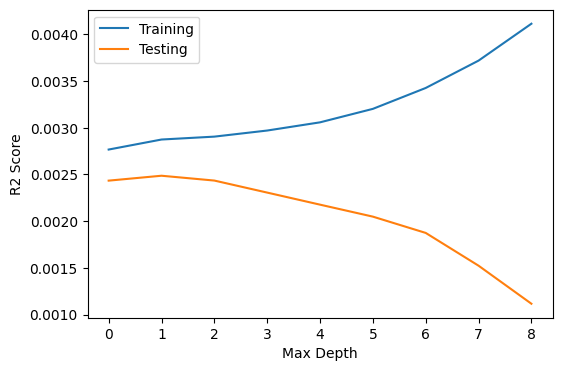

In [207]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Regressor 

In [208]:
df = pd.read_excel('weather_data_excel.xlsx')

In [209]:
df['Date'] = pd.to_datetime(df['Date'])

In [210]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [211]:
location_encoder = LabelEncoder()
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])

In [212]:
# Establish X and y
y = df['Precipitation_mm']
X = df.drop(columns=['Precipitation_mm','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [213]:
# Check if the correct columns for X have been added
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [214]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [215]:
# Create XGBoost Regression Model
import xgboost
xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [216]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [217]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.031871178280234

In [218]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.028456828603085516

### Test XGBoost Regressor at depths 1 through 10

In [219]:
training_r2 = []
testing_r2 = []

In [220]:
for depth in range(1, 20):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror',  n_estimators = 25, max_depth = depth )
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

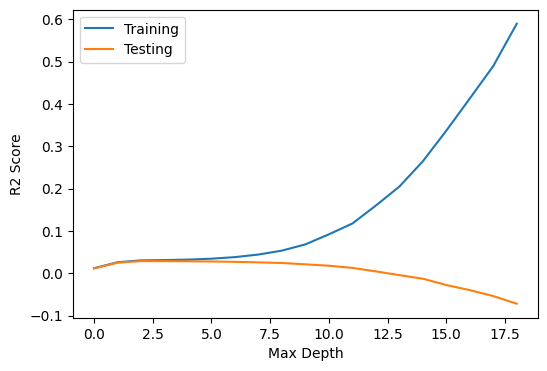

In [221]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier: Percentage Rainfall


In [222]:
data_frame = pd.read_excel('weather_data_excel.xlsx')

In [223]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [224]:
data_frame['Month'] = data_frame['Date'].dt.month
data_frame['Day'] = data_frame['Date'].dt.day
data_frame['Year'] = data_frame['Date'].dt.year

In [225]:
location_encoder = LabelEncoder()

In [226]:
data_frame['Location_encoded'] = location_encoder.fit_transform(data_frame['Location'])

In [227]:
# This is the threshold, in mm, for if rainfall is classified as rain or not
threshold = 5.0
data_frame['Rainfall'] = (data_frame['Precipitation_mm'] >= threshold).astype(int)

In [228]:
y=data_frame['Rainfall']

In [229]:
X = data_frame.drop(columns=['Precipitation_in', 'Precipitation_mm', 'Date', 'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Location', 'Rainfall', 'Date_Time', 'Temperature_C'])

In [230]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [232]:
xgb_c = xgboost.XGBClassifier( n_estimators = 100, max_depth = 10 )

In [233]:
xgb_c.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [234]:
y_train_pred = xgb_c.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
training_accuracy

0.678985

In [235]:
y_test_pred = xgb_c.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
testing_accuracy


0.511295

In [236]:
# Saving the model and encoder
#dump(xgb_c, 'rain_probability_predictor.pkl')
#dump(location_encoder, 'location_encoder.pkl')

### Visualise Data

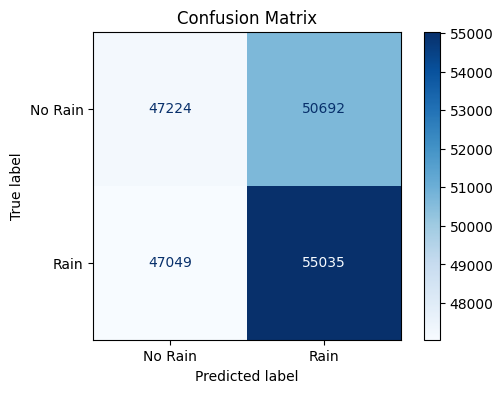

In [237]:
y_pred = xgb_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [238]:
# Write XGB Classifier Code Here

## Tensor Flow Neuro Network

In [239]:
# Write Tensor Flow Neuro Network Code Here